# Musical Quartet Games Statistics

This is some analysis code written for a presentation at Cologne University in May 2025. Its aim is to provide statistical analysis about card games featuring sets of "great composers" from the late 19th / early 20th century. The Notebook file consists of some cells providing different statistics:

+ **Composer Lifespan Analysis:** Plots the life spans of the composers chosen for each game and cumulatively
+ **Composer Presence Overview:** Provides an overview about which composers occur in which game
+ **Canonization Levels:** Provides an overview about "canonization levels" of composers as depicted in those games
+ **Gender Statistics:** Provides gender statistics -- kind of unnecessary given the current data
+ **Temporal Density Heatmaps:** Provides density heatmaps about which time periods are more or less populated with composer mentions (as an afterthought to the life spans plot)
+ **Geographical Representation:** Provides geographical information about which countries are represented. This is somewhat speculative as it does not take into account historical geography, and problems with composers like Handel or Liszt who do not neatly fit into national categories. However, the results are impressive to observe. I assembled this code with lots of inspiration and help from pre-existing geo data analysis code.

### Data Source
The data itself is stored in `game_data.py`. Currently, there's only three game sets evaluated, but it is super-easy to add new games to that file.

### Shape Files
The geodata analysis needs files from the *Natural Earth* project in a `subfolder ne_110m_admin_0_countries`. The data is included in this repository, originating from the [Natural Earth project](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) and labeled as Public Domain there.

For questions or feedback, contact me at christoph.hust@hmt-leipzig.de.

In [8]:
import matplotlib.pyplot as plt

from collections import Counter
from matplotlib.colors import ListedColormap, BoundaryNorm
from game_data import composers, games


LEFT_BORDER, RIGHT_BORDER = 1650, 1950

composer_dict = {composer["ID"] : composer for composer in composers}

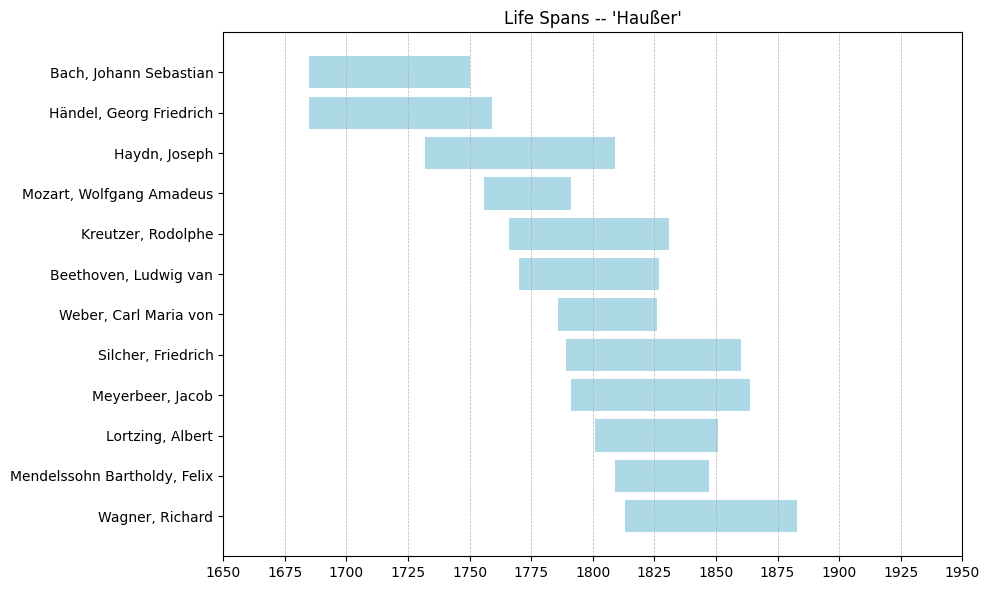

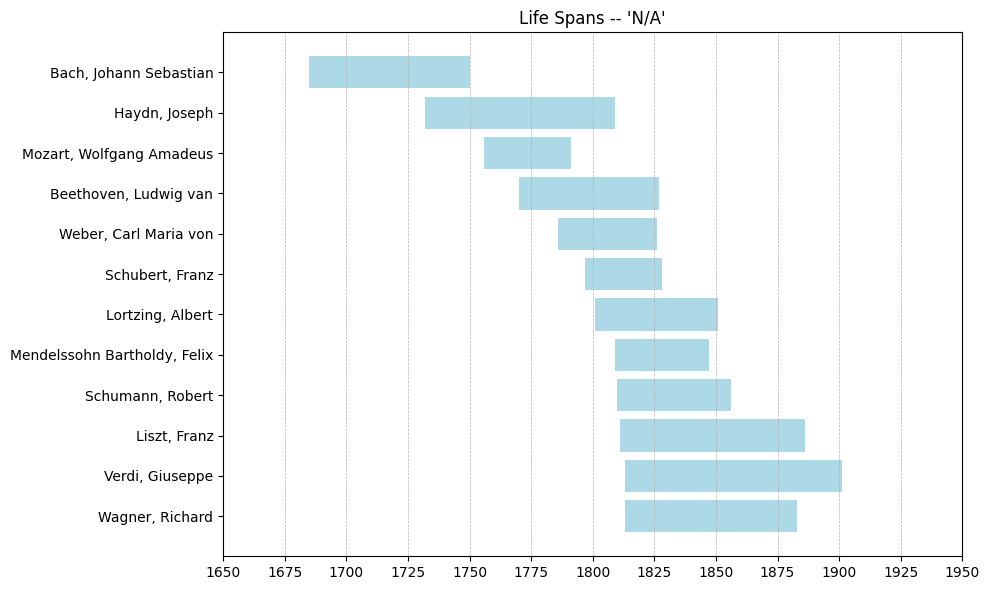

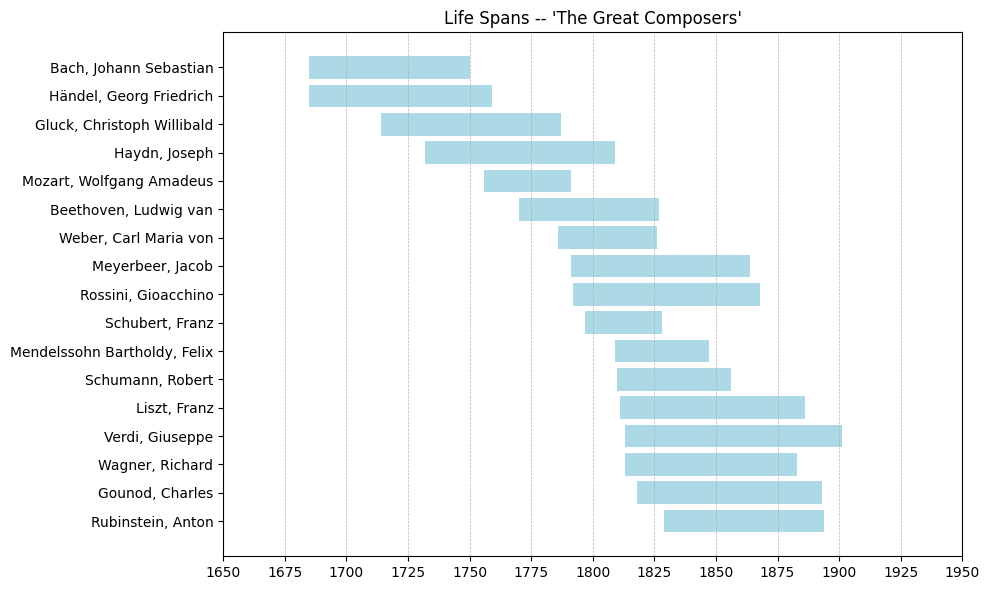

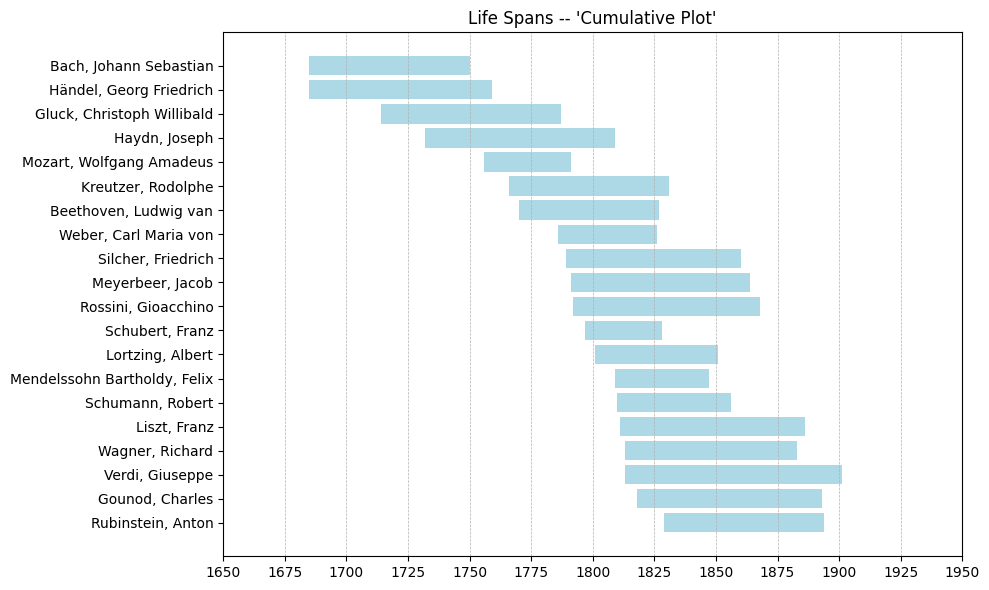

In [9]:
def plot_game(game_title, composer_ids):
    composers = [composer_dict[composer] for composer in composer_ids]
    composers.sort(key=lambda composer: composer["birth_year"])

    fig, ax = plt.subplots(figsize=(10, 6))
    for composer in composers:
        ax.barh(
            composer["name"], composer["death_year"] - composer["birth_year"], left=composer["birth_year"], color="lightblue"
        )

    ax.set_xlim(LEFT_BORDER, RIGHT_BORDER)
    ax.set_xticks(range(LEFT_BORDER, RIGHT_BORDER + 1, 25))
    ax.grid(axis="x", linestyle="--", linewidth=.5)
    ax.set_title(f"Life Spans -- '{game_title}'")
    ax.invert_yaxis()
    fig.tight_layout()

    plt.show()


for game in games:
    plot_game(game["ident"], game["contents"])

plot_game("Cumulative Plot", {composer_id for game in games for composer_id in game["contents"]})

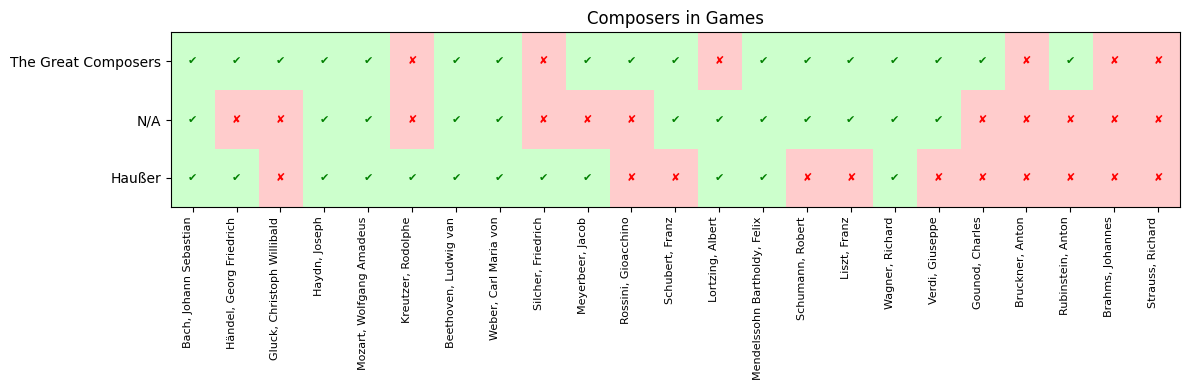

In [10]:
composers_chronological = sorted(composer_dict.values(), key=lambda composer: composer["birth_year"])    # order by year
names = [composer["name"] for composer in composers_chronological]
ids   = [composer["ID"] for composer in composers_chronological]

composers_in_game = []
for game in games:
    row = []
    for composer_id in ids:
        row.append(composer_id in game["contents"])
    composers_in_game.append(row)

fig, ax = plt.subplots(figsize=(12, 4))
cmap = ListedColormap(["#ffcccc", "#ccffcc"])           # red and green
ax.imshow(composers_in_game, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90, ha="right", fontsize=8)
ax.set_yticks(range(len(games)))
ax.set_yticklabels([game["ident"] for game in games], fontsize=10)

ax.invert_yaxis()

for game_index in range(len(composers_in_game)):
    for composer_index in range(len(composers_in_game[game_index])):
        symbol = "✔"     if composers_in_game[game_index][composer_index] else "✘"
        color  = "green" if composers_in_game[game_index][composer_index] else "red"
        ax.text(composer_index, game_index, symbol, color=color, ha="center", va="center", fontsize=8)

ax.set_title("Composers in Games")
plt.tight_layout()

plt.show()

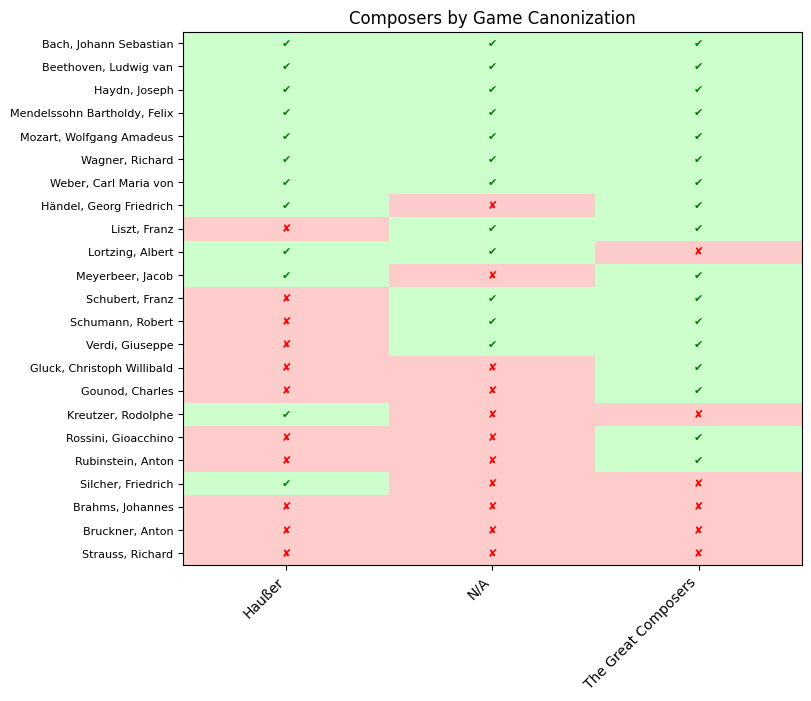

In [11]:
canonization_level = {
    composer_id: sum(composer_id in game["contents"] for game in games) for composer_id in composer_dict
}

sorted_composers = sorted(                                  # sort by descending frequency, then by name
    composer_dict.values(),
    key=lambda composer: (-canonization_level[composer["ID"]], composer["name"])
)

composer_names = [composer["name"]  for composer in sorted_composers]
composer_ids   = [composer["ID"]    for composer in sorted_composers]
game_labels    = [game["ident"]     for game     in games]

composers_in_game = []
for composer_id in composer_ids:
    row = [composer_id in game["contents"] for game in games]
    composers_in_game.append(row)

fig, ax = plt.subplots(
    figsize=(8, len(composer_names) * .3),
    constrained_layout=True
)
cmap = ListedColormap(["#ffcccc", "#ccffcc"])
ax.imshow(composers_in_game, cmap=cmap, aspect="auto", origin="upper")

ax.set_xticks(range(len(game_labels)))
ax.set_xticklabels(game_labels, rotation=45, ha="right", fontsize=10)
ax.set_yticks(range(len(composer_names)))
ax.set_yticklabels(composer_names, fontsize=8)

for game_index in range(len(composers_in_game)):
    for composer_index in range(len(composers_in_game[game_index])):
        symbol = "✔"     if composers_in_game[game_index][composer_index] else "✘"
        color  = "green" if composers_in_game[game_index][composer_index] else "red"
        ax.text(composer_index, game_index, symbol, color=color, ha="center", va="center", fontsize=8)

ax.set_title("Composers by Game Canonization")

plt.show()

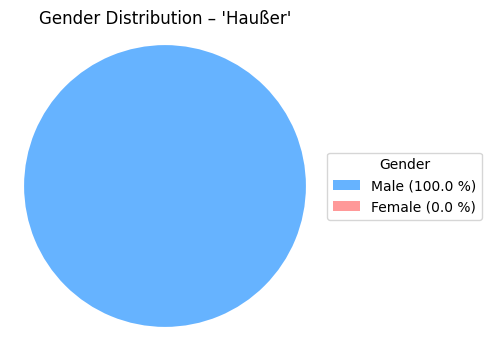

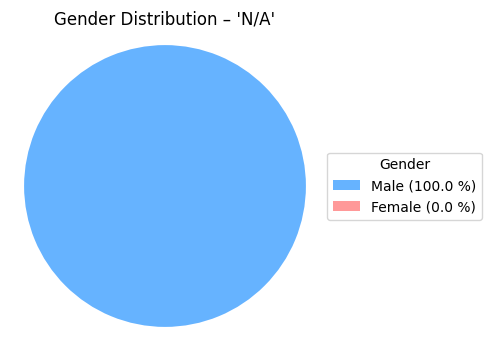

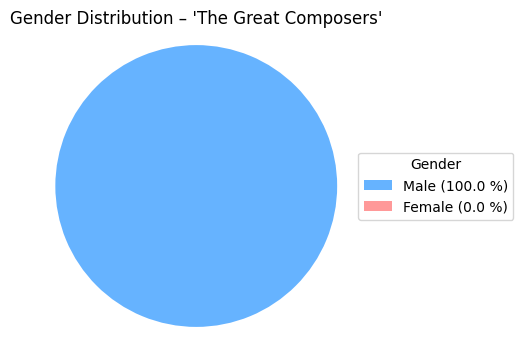

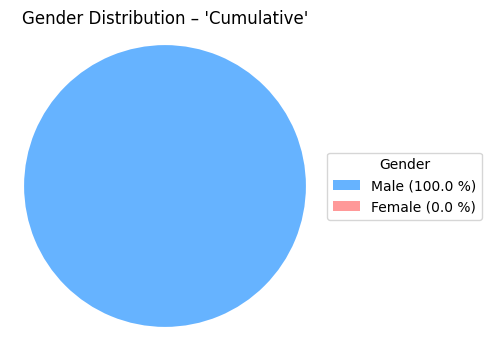

In [12]:
game_sets = [(game["ident"], game["contents"]) for game in games]
cumulative_ids = set(composer_id for game in games for composer_id in game["contents"])
game_sets.append(("Cumulative", cumulative_ids))

for label, ids in game_sets:
    genders = Counter(composer_dict[composer_id]["gender"] for composer_id in ids)
    total   = sum(genders.values())

    sizes = [genders.get("m", 0), genders.get("f", 0)]
    legend_labels = [
        f"Male ({100 * sizes[0] / total:.1f} %)",
        f"Female ({100 * sizes[1] / total:.1f} %)"
    ]

    fig, ax   = plt.subplots(figsize=(4, 4))
    wedges, _ = ax.pie(sizes, colors=["#66b3ff", "#ff9999"], startangle=90)
    ax.axis("equal")

    ax.legend(wedges, legend_labels, title="Gender", loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(f"Gender Distribution – '{label}'")

    plt.show()

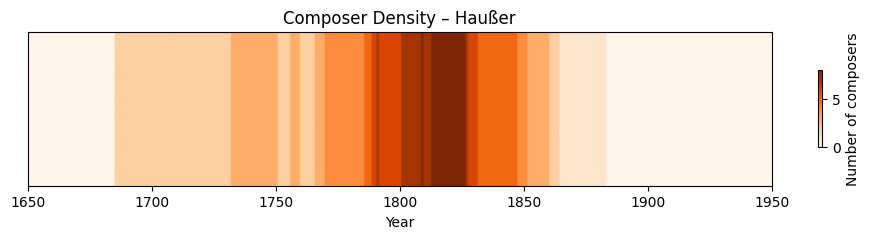

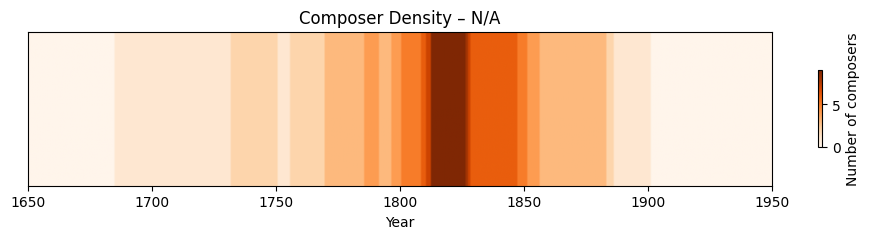

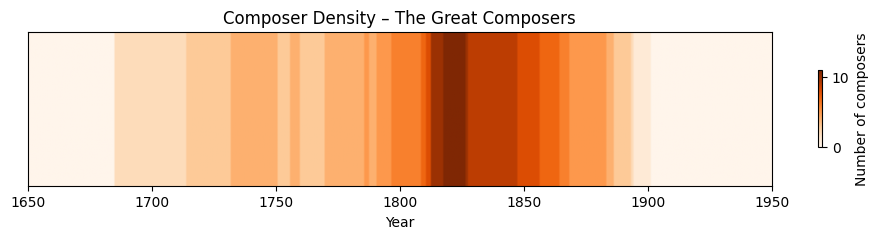

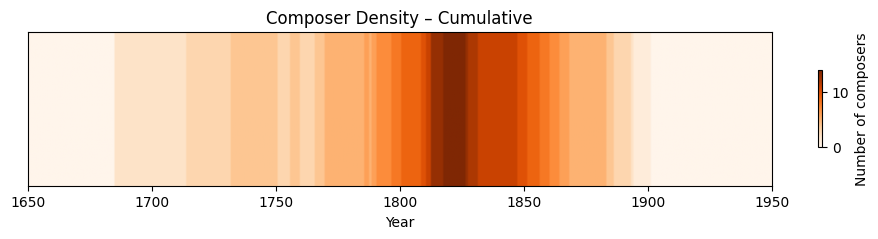

In [13]:
def get_density(ids):
    density = [0] * len(list(range(LEFT_BORDER, RIGHT_BORDER + 1)))

    for composer_id in ids:
        for year in range(composer_dict[composer_id]["birth_year"], composer_dict[composer_id]["death_year"] + 1):
            density[year - LEFT_BORDER] += 1

    return density


def lifetime_heatmap(density, title):
    fig, ax = plt.subplots(figsize=(12, 2))
    im = ax.imshow([density], cmap="Oranges", aspect="auto", extent=[LEFT_BORDER, RIGHT_BORDER, 0, 1])
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlim(LEFT_BORDER, RIGHT_BORDER)
    ax.set_xlabel("Year")
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=.5)
    cbar.set_label("Number of composers")

    plt.show()


for game in games:
    density = get_density(game["contents"])
    lifetime_heatmap(density, f"Composer Density – {game['ident']}")

all_ids = {composer_id for game in games for composer_id in game["contents"]}
density_cum = get_density(all_ids)
lifetime_heatmap(density_cum, "Composer Density – Cumulative")

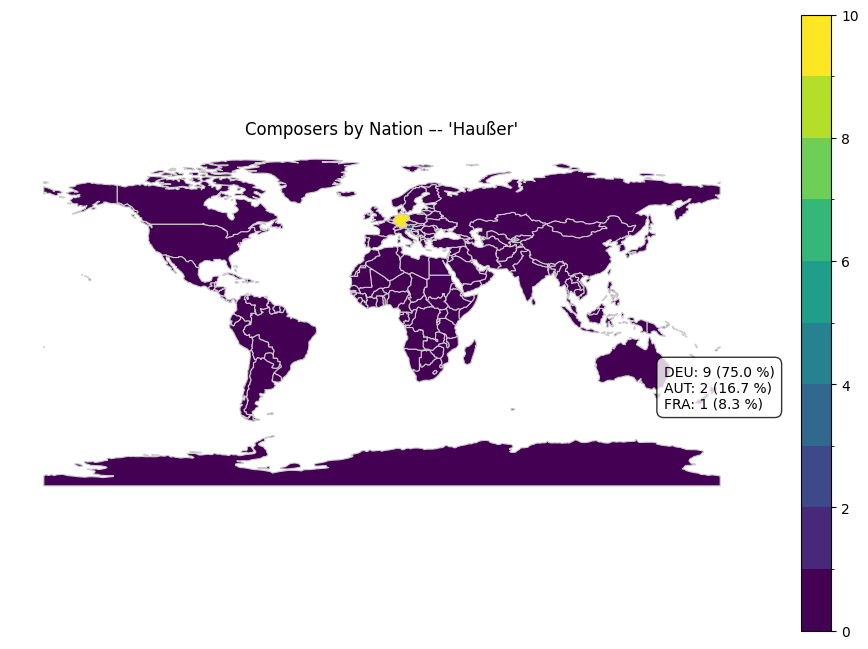

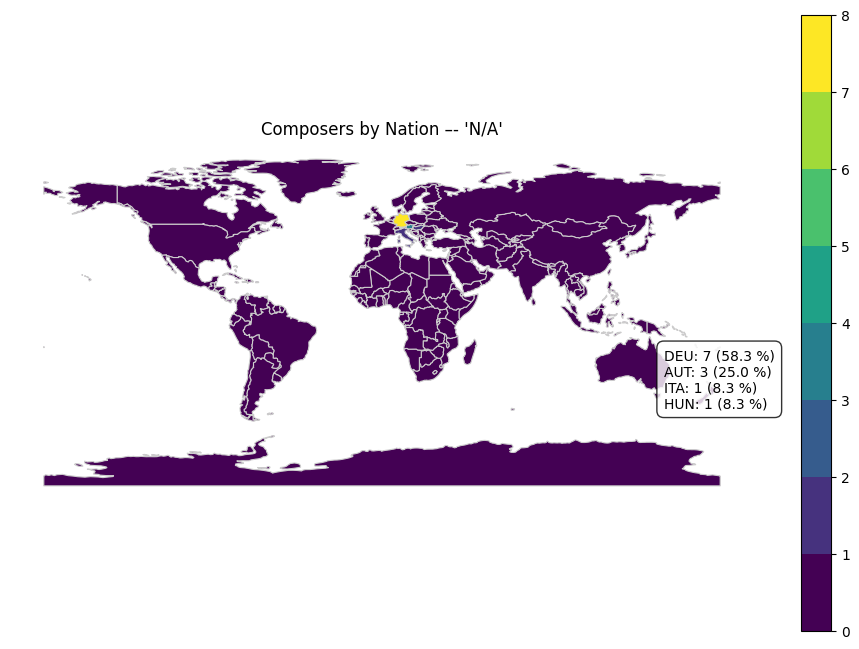

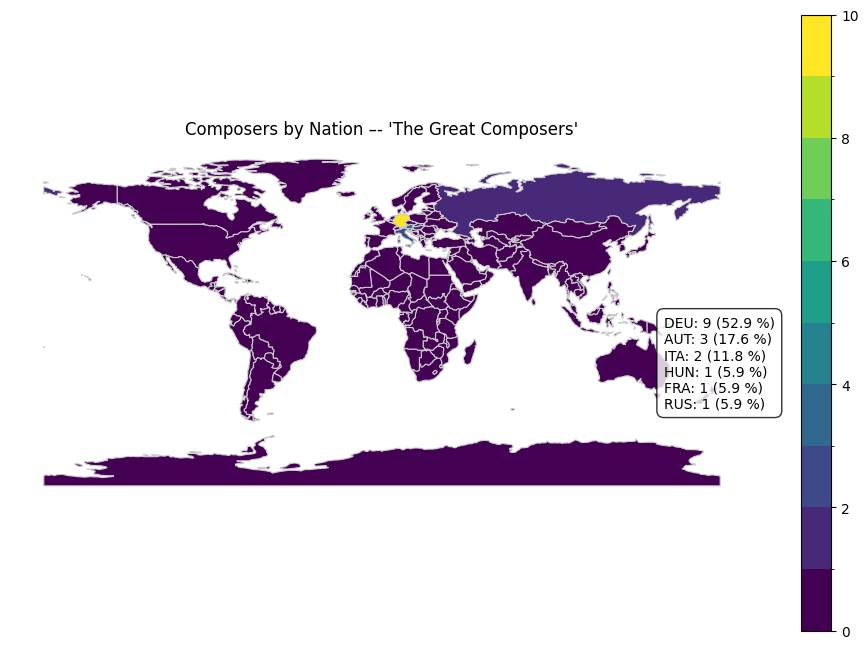

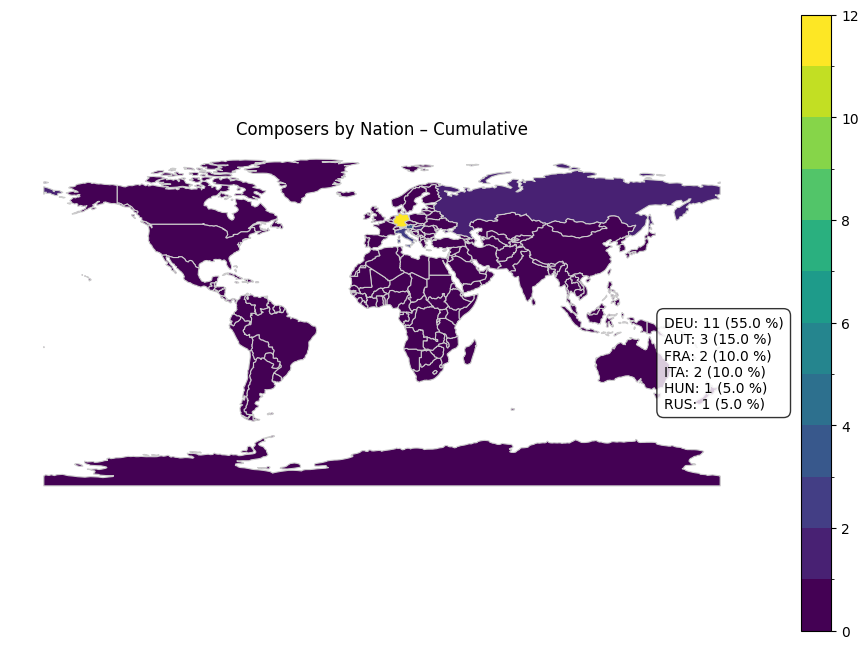

In [14]:
import pandas as pd
import geopandas as gpd

from matplotlib.pyplot import colormaps


world_map = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")


def count_nations(ids):
    return Counter(composer_dict[composer_id]["nation"] for composer_id in ids)

def plot_nation_map(nation_counts, title):
    nation_counts_df = pd.DataFrame.from_dict(nation_counts, orient="index", columns=["count"]).reset_index()
    nation_counts_df.columns = ["iso_a3", "count"]
    nation_counts_df["percent"] = nation_counts_df["count"] / nation_counts_df["count"].sum() * 100

    merged = world_map.merge(nation_counts_df, how="left", left_on="SOV_A3", right_on="iso_a3")
    merged["count"] = merged["count"].fillna(0)

    max_count = int(nation_counts_df["count"].max())
    cmap = colormaps["viridis"].resampled(max_count + 1)        # okay alternatives: cividis, magma, viridis, inferno, turbo
    boundaries = list(range(0, max_count + 2))
    norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=(12, 8))
    merged.plot(column="count", cmap=cmap, norm=norm, linewidth=.8, ax=ax, edgecolor=".8", legend=True, legend_kwds={"spacing": "proportional"})
    ax.set_title(title)
    ax.axis("off")

    legend_entries_df = nation_counts_df[nation_counts_df["count"] > 0].sort_values("count", ascending=False)
    lines = [f"{row['iso_a3']}: {int(row['count'])} ({row['percent']:.1f} %)" for _, row in legend_entries_df.iterrows()]
    legend_text = "\n".join(lines)
    ax.text(
        150, -50, legend_text, fontsize=10, va="bottom",
        bbox=dict(boxstyle="round,pad=.5", facecolor="white", alpha=0.8)
    )

    plt.show()


for game in games:
    nation_counts = count_nations(game["contents"])
    plot_nation_map(nation_counts, f"Composers by Nation –- '{game['ident']}'")

all_ids = {composer_id for game in games for composer_id in game["contents"]}
plot_nation_map(count_nations(all_ids), "Composers by Nation – Cumulative")